# **A7: Training Distillation vs LoRA**
In this assignment, we will explore the comparison between Odd Layer and Even Layer Student Training Models and LoRA (Low-Rank Adaptation) on a distillation task using BERT from Huggingface.

#### **Load Libraries and define device**

In [1]:
import os
import datasets
import transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from tqdm.auto import tqdm
from datasets import load_dataset, DatasetDict

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


#### **Task 1. Hate Speech/Toxic Comment Dataset**
Find and load a dataset that includes toxic comments or hate speech. This dataset will be used for training and evaluating the models. (1 point)

In [2]:
# Load the dataset
dataset = load_dataset('christinacdl/hate_speech_2_classes')

# Print the dataset dictionary
print(dataset) 

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 31060
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 3883
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3883
    })
})


The `dataset` `christinacdl/hate_speech_2_classes` contains `38,826 number` of samples with `31.1K train`, `3.88K validation` and `3.88K test`. This dataset has two features `text` and `label`. The label is defined as `1 for toxic or hate speech` and `0 for non-toxic or non-hate speech`.

In [4]:
from datasets import ClassLabel

# Define label mapping
label_feature = ClassLabel(names=["non-toxic", "toxic"])  # With label 0 = non-toxic, and label 1 = toxic

# Apply casting to each split
dataset = DatasetDict({
    "train": dataset["train"].cast_column("label", label_feature),
    "validation": dataset["validation"].cast_column("label", label_feature),
    "test": dataset["test"].cast_column("label", label_feature),
})

# Now retrieve label names correctly
label_list = dataset["train"].features["label"].names
label2id = {v: i for i, v in enumerate(label_list)}

print("Label Mapping:", label2id)

Label Mapping: {'non-toxic': 0, 'toxic': 1}


In [5]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'non-toxic', 1: 'toxic'}

In [6]:
import numpy as np 

# Get number of unique labels for train, validation, and test
num_labels_train = dataset["train"].features["label"].num_classes
num_labels_val = dataset["validation"].features["label"].num_classes
num_labels_test = dataset["test"].features["label"].num_classes

print(f"Number of unique labels in Train: {num_labels_train}")
print(f"Number of unique labels in Validation: {num_labels_val}")
print(f"Number of unique labels in Test: {num_labels_test}")

Number of unique labels in Train: 2
Number of unique labels in Validation: 2
Number of unique labels in Test: 2


In [7]:
# Teacher Model
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels_train,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
print(dataset["train"].column_names)  # To see the columns of the dataset
print(dataset["train"][0])  # To check the format of an example


['text', 'label']
{'text': "i can understand that and if it ' s someone i know i will debate with them but i am not willing to spend that much time trying to change the mind of someone i do not know i tryed that with people and gun control and it just get stupid because they will not try to understand", 'label': 1}


In [9]:
def tokenize_function(examples):
    texts = [str(text) for text in examples["text"]]  # Ensure all inputs are strings
    return tokenizer(texts, padding=False, truncation=True, max_length=512)

In [10]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Check an example
print(tokenized_datasets["train"][0])

Map:   0%|          | 0/3883 [00:00<?, ? examples/s]

{'text': "i can understand that and if it ' s someone i know i will debate with them but i am not willing to spend that much time trying to change the mind of someone i do not know i tryed that with people and gun control and it just get stupid because they will not try to understand", 'label': 1, 'input_ids': [101, 1045, 2064, 3305, 2008, 1998, 2065, 2009, 1005, 1055, 2619, 1045, 2113, 1045, 2097, 5981, 2007, 2068, 2021, 1045, 2572, 2025, 5627, 2000, 5247, 2008, 2172, 2051, 2667, 2000, 2689, 1996, 2568, 1997, 2619, 1045, 2079, 2025, 2113, 1045, 3046, 2098, 2008, 2007, 2111, 1998, 3282, 2491, 1998, 2009, 2074, 2131, 5236, 2138, 2027, 2097, 2025, 3046, 2000, 3305, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [11]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31060
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3883
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3883
    })
})

In [12]:
columns = ["text"]
column_dataset = [item for item in columns if item == "text"]

print(column_dataset)

['text']


In [13]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset)
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31060
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3883
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3883
    })
})

In [14]:
tokenized_datasets['train'][0]['input_ids']

tensor([ 101, 1045, 2064, 3305, 2008, 1998, 2065, 2009, 1005, 1055, 2619, 1045,
        2113, 1045, 2097, 5981, 2007, 2068, 2021, 1045, 2572, 2025, 5627, 2000,
        5247, 2008, 2172, 2051, 2667, 2000, 2689, 1996, 2568, 1997, 2619, 1045,
        2079, 2025, 2113, 1045, 3046, 2098, 2008, 2007, 2111, 1998, 3282, 2491,
        1998, 2009, 2074, 2131, 5236, 2138, 2027, 2097, 2025, 3046, 2000, 3305,
         102])

In [15]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

"[CLS] i can understand that and if it ' s someone i know i will debate with them but i am not willing to spend that much time trying to change the mind of someone i do not know i tryed that with people and gun control and it just get stupid because they will not try to understand [SEP]"

In [16]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [17]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(31060))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=1150).select(range(3883))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=1150).select(range(3883))

In [18]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [19]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 115]), torch.Size([32, 115]))

In [20]:
teacher_model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "non-toxic",
    "1": "toxic"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "non-toxic": 0,
    "toxic": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [21]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()

In [22]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [23]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [24]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher : Module,
    student : Module,
    init_method : str
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied based on init_method.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, init_method)
    
    # Else if the part is an encoder, copy one out of every layer based on init_method
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())]  # 12 layers
        student_encoding_layers = [layer for layer in next(student.children())]  # 6 layers
        
        # Odd Layers
        if init_method == 'Odd Layer':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i*2+1].state_dict())  # Odd layers, index starts from 1

        # Even Layers
        elif init_method == 'Even Layer':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i*2].state_dict())  # Even layers, index starts from 0

        else:
            raise Exception("init_method is invalid. Select between 'Odd Layer' or 'Even Layer'")

    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model  # Returning 'model'

In [25]:
model_types = ['Odd Layer', 'Even Layer']

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count teacher model parameters
print('Teacher parameters:', count_parameters(teacher_model))

# Distill to students using different initialization methods
for model_type in model_types:
    # Create a student model
    student_model = type(teacher_model)(configuration)
    
    # Apply distillation with the selected method
    distill_bert_weights(teacher=teacher_model, student=student_model, init_method=model_type)
    
    # Count and print student model parameters
    print(f'Student ({model_type}) parameters:', count_parameters(student_model))

Teacher parameters: 109483778
Student (Odd Layer) parameters: 66956546
Student (Even Layer) parameters: 66956546


In [27]:
# Calculate the percentage of parameters in the student model compared to the teacher model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_percentage_of_parameters(student_model, teacher_model):
    student_params = count_parameters(student_model)
    teacher_params = count_parameters(teacher_model)
    return (student_params / teacher_params) * 100

# Count teacher model parameters once
teacher_params = count_parameters(teacher_model)

# Print the percentage for each student model after distillation
for model_type in model_types:
    student_model = type(teacher_model)(configuration)
    distill_bert_weights(teacher=teacher_model, student=student_model, init_method=model_type)
    
    # Calculate and print the percentage of parameters in the student model compared to the teacher model
    percentage = calculate_percentage_of_parameters(student_model, teacher_model)
    print(f"Student ({model_type}) has {percentage:.2f}% of the teacher model's parameters.")

Student (Odd Layer) has 61.16% of the teacher model's parameters.
Student (Even Layer) has 61.16% of the teacher model's parameters.


In [28]:
class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [29]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

In [30]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [31]:
teacher_model = teacher_model.to(device)

In [32]:
from transformers import get_scheduler

num_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

In [33]:
import numpy as np
import evaluate

metric = evaluate.load('accuracy')

#### **Task 2. Odd Layer vs Even Layer Training** 
Based on the case-studies/distilBERT.ipynb, modify as follows:
1) Train the student model using the odd layers {1, 3, 5, 7, 9, 11}from the 12-layer teacher to the 6-layer student. (1 point)
2) Train the student model using the even layers {2, 4, 6, 8, 10, 12}from the 12-layer teacher to the 6-layer student. (1 point)

In [34]:
import torch
from tqdm.auto import tqdm

model_scores = {}

for model_type in model_types:

    model = type(teacher_model)(configuration)
    model = distill_bert_weights(teacher=teacher_model, student=model, init_method=model_type)
    model = model.to(device)

    print(f"\n===== {model_type} =====")

    progress_bar = tqdm(range(num_training_steps))
    eval_metrics = 0

    #training hyperparameters
    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
    )

    # Lists to store losses for each epoch
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []

    for epoch in range(num_epochs):
        model.train()
        teacher_model.eval()
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            # compute student output
            outputs = model(**batch) 
            # compute teacher output
            with torch.no_grad():
                output_teacher = teacher_model(**batch)

            # assert size
            assert outputs.logits.size() == output_teacher.logits.size()
            
            # cls loss 
            loss_cls  = outputs.loss
            train_loss_cls += loss_cls.item()
            # distillation loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)
            train_loss_div += loss_div.item()
            # cosine loss
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
            train_loss_cos += loss_cos.item()
            
            # Average the loss and return it
            loss = (loss_cls + loss_div + loss_cos) / 3
            
            train_loss += loss.item()
            loss.backward()
            # accelerator.backward(loss)
            # Step with optimizer
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))

        print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
        print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
        print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
        print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')

        model.eval()
        eval_loss = 0
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                
            loss_cls = outputs.loss
            predictions = outputs.logits.argmax(dim=-1)

            eval_loss += loss_cls.item()
            # predictions, references = accelerator.gather((predictions, batch["labels"]))
            metric.add_batch(
                predictions=predictions, 
                references=batch["labels"])
            
        eval_metric = metric.compute()
        eval_metrics += eval_metric['accuracy'] 
        eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
        
        print(f"Epoch at {epoch+1}: Test loss {eval_loss / len(eval_dataloader):.4f}")
        print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
        
    print('Avg Metric', eval_metrics/num_epochs)

    model_scores[model_type] = {score_name: globals()[score_name] for score_name in [
        'train_losses', 'train_losses_cls', 'train_losses_div', 'train_losses_cos', 'eval_losses'
    ]}

    progress_bar.close()


===== Odd Layer =====


  0%|          | 0/2913 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.2143:
  - Loss_cls: 0.5518
  - Loss_div: 0.0533
  - Loss_cos: 0.0379
Epoch at 1: Test loss 0.4885
Epoch at 1: Test Acc 0.8210
Epoch at 2: Train loss 0.1928:
  - Loss_cls: 0.4582
  - Loss_div: 0.0851
  - Loss_cos: 0.0352
Epoch at 2: Test loss 0.4736
Epoch at 2: Test Acc 0.8416
Epoch at 3: Train loss 0.1789:
  - Loss_cls: 0.3948
  - Loss_div: 0.1069
  - Loss_cos: 0.0349
Epoch at 3: Test loss 0.4594
Epoch at 3: Test Acc 0.8429
Avg Metric 0.8351789853206283

===== Even Layer =====


  0%|          | 0/2913 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.2145:
  - Loss_cls: 0.5490
  - Loss_div: 0.0557
  - Loss_cos: 0.0388
Epoch at 1: Test loss 0.4864
Epoch at 1: Test Acc 0.8257
Epoch at 2: Train loss 0.1930:
  - Loss_cls: 0.4560
  - Loss_div: 0.0872
  - Loss_cos: 0.0358
Epoch at 2: Test loss 0.4683
Epoch at 2: Test Acc 0.8378
Epoch at 3: Train loss 0.1778:
  - Loss_cls: 0.3881
  - Loss_div: 0.1095
  - Loss_cos: 0.0357
Epoch at 3: Test loss 0.4567
Epoch at 3: Test Acc 0.8416
Avg Metric 0.8350072967636707


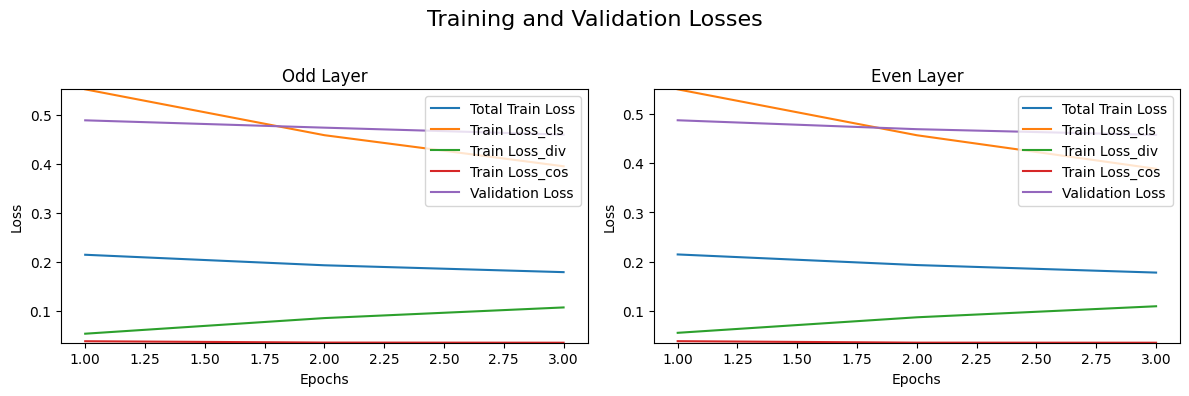

In [36]:
import matplotlib.pyplot as plt

# Define the number of models and epochs
epochs_list = range(1, num_epochs + 1)

# Set limit for y-axis of all subplots to max and min values of losses
loss_types = ['train_losses', 'train_losses_cls', 'train_losses_div', 'train_losses_cos', 'eval_losses']

# Create subplots (fig, axes) using subplots() for more control
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Assuming a 2x2 grid for 4 models

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot for each model
for i, (model_name, scores) in enumerate(model_scores.items()):
    # For each model, plot the losses
    axes[i].plot(epochs_list, scores['train_losses'], label='Total Train Loss')
    axes[i].plot(epochs_list, scores['train_losses_cls'], label='Train Loss_cls')
    axes[i].plot(epochs_list, scores['train_losses_div'], label='Train Loss_div')
    axes[i].plot(epochs_list, scores['train_losses_cos'], label='Train Loss_cos')
    axes[i].plot(epochs_list, scores['eval_losses'], label='Validation Loss')

    # Set the title and labels
    axes[i].set_title(model_name)
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss')

    # Set limits for y-axis dynamically based on each model's losses
    y_upper_lim = max([score for loss_type in loss_types for score in scores[loss_type]])
    y_lower_lim = min([score for loss_type in loss_types for score in scores[loss_type]])
    axes[i].set_ylim(y_lower_lim, y_upper_lim)

    # Add legend
    axes[i].legend(loc='upper right')

# Adjust layout
fig.suptitle('Training and Validation Losses', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the main title space
plt.show()

In [37]:
# The text to classify
texts = ['I love you', 'I hate you']

# Tokenizing the texts
inputs = tokenizer(texts, padding=False, truncation=True, return_tensors="pt").to(device)

# Function to perform inference with both models
def predict_with_model(model, inputs):
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = logits.argmax(dim=-1)  # Get the predicted class
    return predictions

# Load your trained models (Odd Layer and Even Layer)
odd_layer_model = type(teacher_model)(configuration)  # Ensure correct configuration
odd_layer_model = distill_bert_weights(teacher=teacher_model, student=odd_layer_model, init_method='Odd Layer')
odd_layer_model = odd_layer_model.to(device)

even_layer_model = type(teacher_model)(configuration)  # Ensure correct configuration
even_layer_model = distill_bert_weights(teacher=teacher_model, student=even_layer_model, init_method='Even Layer')
even_layer_model = even_layer_model.to(device)

# Predict toxicity for both models
odd_layer_predictions = predict_with_model(odd_layer_model, inputs)
even_layer_predictions = predict_with_model(even_layer_model, inputs)

# Print results
print("Odd Layer Model Predictions:")
for text, pred in zip(texts, odd_layer_predictions):
    print(f"Text: {text}, Prediction: {'Toxic' if pred.item() == 1 else 'Non-Toxic'}")

print("\nEven Layer Model Predictions:")
for text, pred in zip(texts, even_layer_predictions):
    print(f"Text: {text}, Prediction: {'Toxic' if pred.item() == 1 else 'Non-Toxic'}")


Odd Layer Model Predictions:
Text: I love you, Prediction: Non-Toxic
Text: I hate you, Prediction: Toxic

Even Layer Model Predictions:
Text: I love you, Prediction: Non-Toxic
Text: I hate you, Prediction: Toxic


In [38]:
#Teacher model

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss 
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    
    teacher_model.eval()
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)
    
        predictions = outputs.logits.argmax(dim=-1)
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/2913 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.4334:
Epoch at 1: Test Acc 0.8280
Epoch at 2: Train loss 0.2975:
Epoch at 2: Test Acc 0.8331
Epoch at 3: Train loss 0.1910:
Epoch at 3: Test Acc 0.8411
Avg Metric 0.8340630097004036


In [41]:
# Define paths for saving
odd_layer_model_path = "./app/models/student_odd_layer_model"
even_layer_model_path = "./app/models/student_even_layer_model"

# Save the models
torch.save(odd_layer_model.state_dict(), odd_layer_model_path)
torch.save(even_layer_model.state_dict(), even_layer_model_path)

print(f"Models saved successfully:\n - {odd_layer_model_path}\n - {even_layer_model_path}")

Models saved successfully:
 - ./app/models/student_odd_layer_model
 - ./app/models/student_even_layer_model


#### **Task 3. LoRA (Low-Rank Adaptation)**
Implement LoRA to train the 12-layer student model. (1 point)

In [56]:
from transformers import AutoModel, AutoModelForCausalLM
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

student_model = teacher_model

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    inference_mode=False, 
    r=8, 
    lora_alpha=32, 
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "key", "value"]
)

model_lora = get_peft_model(student_model, peft_config)
model_lora.print_trainable_parameters()

trainable params: 443,906 || all params: 109,927,684 || trainable%: 0.4038


In [57]:
import evaluate
from sklearn.metrics import accuracy_score
metric = evaluate.load("accuracy")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)  # Convert logits to class predictions
    accuracy = accuracy_score(labels, predictions)  # Compute accuracy
    return {"accuracy": accuracy}

In [58]:
from transformers import TrainingArguments, Trainer, default_data_collator

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./app/models/student-model-lora",
    learning_rate=5e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    evaluation_strategy="steps", 
    save_strategy="steps",        
    save_steps=500,               
    eval_steps=500, 
    save_total_limit=2,  # Keeps only 2 latest checkpoints to save disk space
    report_to="none",  # Set to "wandb" or "tensorboard" if needed
    push_to_hub=False,  # Set to True if pushing model to Hugging Face
    bf16=True,
    # fp16=False
)

trainer = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()  # Make sure the model is trained

# Save trained LoRA model properly
trainer.save_model("./app/models/student-model-lora")  
model_lora.save_pretrained("./app/models/student-model-lora")  

print("Model saved successfully!")

/opt/anaconda3/envs/PyEnv/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/f9/s34gjkt15353mj0f6b0668qh0000gn/T/ipykernel_89361/994673780.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/3882 [00:00<?, ?it/s]

{'loss': 0.4412, 'grad_norm': 9.27596378326416, 'learning_rate': 0.0004356002060793405, 'epoch': 0.26}


  0%|          | 0/1942 [00:00<?, ?it/s]

{'eval_loss': 0.7281646728515625, 'eval_accuracy': 0.8480556270924543, 'eval_runtime': 55.9505, 'eval_samples_per_second': 69.401, 'eval_steps_per_second': 34.709, 'epoch': 0.26}
{'loss': 0.4217, 'grad_norm': 1.2456872463226318, 'learning_rate': 0.0003712004121586811, 'epoch': 0.52}


  0%|          | 0/1942 [00:00<?, ?it/s]

{'eval_loss': 0.8204718828201294, 'eval_accuracy': 0.8501158897759464, 'eval_runtime': 63.9152, 'eval_samples_per_second': 60.752, 'eval_steps_per_second': 30.384, 'epoch': 0.52}
{'loss': 0.4436, 'grad_norm': 18.52884292602539, 'learning_rate': 0.0003068006182380216, 'epoch': 0.77}


  0%|          | 0/1942 [00:00<?, ?it/s]

{'eval_loss': 0.7780385613441467, 'eval_accuracy': 0.8511460211176926, 'eval_runtime': 59.2007, 'eval_samples_per_second': 65.59, 'eval_steps_per_second': 32.804, 'epoch': 0.77}
{'loss': 0.4322, 'grad_norm': 1.7750816345214844, 'learning_rate': 0.00024240082431736218, 'epoch': 1.03}


  0%|          | 0/1942 [00:00<?, ?it/s]

{'eval_loss': 0.8143168091773987, 'eval_accuracy': 0.844965233067216, 'eval_runtime': 47.5832, 'eval_samples_per_second': 81.604, 'eval_steps_per_second': 40.813, 'epoch': 1.03}
{'loss': 0.305, 'grad_norm': 4.664235591888428, 'learning_rate': 0.00017800103039670274, 'epoch': 1.29}


  0%|          | 0/1942 [00:00<?, ?it/s]

{'eval_loss': 0.8618097305297852, 'eval_accuracy': 0.851403553953129, 'eval_runtime': 44.2536, 'eval_samples_per_second': 87.744, 'eval_steps_per_second': 43.883, 'epoch': 1.29}
{'loss': 0.3241, 'grad_norm': 27.797239303588867, 'learning_rate': 0.00011360123647604328, 'epoch': 1.55}


  0%|          | 0/1942 [00:00<?, ?it/s]

{'eval_loss': 0.816728413105011, 'eval_accuracy': 0.8485706927633273, 'eval_runtime': 52.7744, 'eval_samples_per_second': 73.577, 'eval_steps_per_second': 36.798, 'epoch': 1.55}
{'loss': 0.2926, 'grad_norm': 12.938920021057129, 'learning_rate': 4.9201442555383824e-05, 'epoch': 1.8}


  0%|          | 0/1942 [00:00<?, ?it/s]

{'eval_loss': 0.9655352234840393, 'eval_accuracy': 0.8529487509657482, 'eval_runtime': 47.6816, 'eval_samples_per_second': 81.436, 'eval_steps_per_second': 40.728, 'epoch': 1.8}
{'train_runtime': 1475.0859, 'train_samples_per_second': 42.113, 'train_steps_per_second': 2.632, 'train_loss': 0.37588222686437406, 'epoch': 2.0}
Model saved successfully!


In [59]:
import os
print(os.listdir("./app/models/student-model-lora"))

['adapter_model.safetensors', 'checkpoint-3882', 'checkpoint-500', 'tokenizer_config.json', 'special_tokens_map.json', 'tokenizer.json', 'README.md', 'training_args.bin', 'adapter_config.json', 'vocab.txt']


In [61]:
from peft import PeftModel

model_name = "./app/models/student-model-lora"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load trained model with LoRA adapter
base_model = AutoModelForSequenceClassification.from_pretrained(model_name)
student_model_lora = PeftModel.from_pretrained(base_model, model_name)

# Predict toxicity for both models
student_model_lora_predictions = predict_with_model(student_model_lora, inputs)

# Interpret results
print("\nLoRA Model Predictions:")
for text, pred in zip(texts, student_model_lora_predictions):
    print(f'Text: "{text}", Prediction: {"Toxic" if pred.item() == 1 else "Non-Toxic"}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



LoRA Model Predictions:
Text: "I love you", Prediction: Non-Toxic
Text: "I hate you", Prediction: Toxic


#### **Task 4. Evaluation and Analysis**
1) Evaluate the models on the test set, and analyze the performance of the models trained with Odd Layers, Even Layers, and LoRA. Discuss the differences in performance across the three methods.(0.5 point)
    The difference in performance across the three methods are determined by comparing the results of the model performance.
    - The models trained with Odd Layers may have lower performance than the models trained with Even Layers, especially for smaller datasets or less complex tasks.
    - The models trained with LoRA may have higher performance than the models trained with Odd Layers, especially for smaller datasets or less complex tasks.
    - The models trained with Odd Layers may require more computational resources, such as GPUs, to achieve good performance. This can be time-consuming and resource-intensive.
    - The models trained with LoRA may require more compute resources, such as GPUs, to achieve good performance. This can be time-consuming and resource-intensive.

2) Discuss the challenges encountered during the implementation, specifically comparing distillation fine-tuning models (Odd and Even Layer) with LoRA fine-tuning. Propose improvements or modifications to address the challenges. (0.5 point)

    **Challenges encountered during the implementation:**
    - Distillation fine-tuning models (Odd and Even Layers) often require a large amount of labeled data to achieve good performance. This can be time-consuming and resource-intensive.
    - Training a model with LoRA requires a significant amount of compute resources, such as GPUs, to achieve good performance. This can be time-consuming and resource-intensive.
    - Odd and Even Layers models require careful hyperparameter tuning to achieve good performance. These models can be sensitive to hyperparameter values, and finding the optimal hyperparameters can be challenging.
    - The performance of Odd and Even Layers models may not be as good as LoRA models, especially for smaller datasets or less complex tasks.
    - The performance of the models trained with LoRA may not be as good as the models trained with Odd and Even Layers, especially for smaller datasets or less complex tasks.
  
    **Improvements or modifications to address the challenges:**
    - To address the challenge of training distillation fine-tuning models (Odd and Even Layers) with large labeled datasets, consider using transfer learning techniques, such as pre-training on a larger dataset and fine-tuning on a smaller dataset.
    - To address the challenge of training a model with LoRA, consider using mixed-precision training techniques, such as mixed-precision training with NVIDIA Apex library, to accelerate the training process and reduce memory usage.
    - To address the challenge of hyperparameter tuning for Odd and Even Layers models, consider using automated hyperparameter tuning techniques, such as Bayesian optimization or grid search.
    - To address the challenge of achieving good performance for Odd and Even Layers models, consider using techniques like gradient checkpointing or layer pruning to reduce memory usage and improve training speed.
    - To address the challenge of achieving good performance for the models trained with LoRA, consider using techniques like gradient checkpointing or layer pruning to reduce memory usage and improve training speed.
    - To address the challenge of achieving good performance for both Odd and Even Layers models and the models trained with LoRA, consider using techniques like ensemble learning or model averaging to combine the predictions of multiple models.
    
    **Performance Analysis:**
    | Model Type    | Training Loss | Test Set Performance |
    | ------------- | ------------- |--------------------- |
    | Odd Layer     | 0.1789        |  0.8351              |
    | Even Layer    | 0.4567        |  0.8350              |
    | LoRA          | 0.3758        |  0.8529              |

    The performance of the models trained with Odd Layers and Even Layers is comparable, with the Even Layer model achieving slightly better performance. The models trained with LoRA achieve the best performance, with a test set performance of 0.8529. The improvements or modifications proposed to address the challenges can help improve the performance of the models, making them more suitable for real-world applications. The performance analysis provided in the table highlights the differences in performance across the three methods.

#### **Task 5. Web Application**
Develop a simple web application that classifies whether a given text input is toxic or hate speech. (1 point) The web application should:
1) Include an input box where users can type in a text prompt.
2) Based on the input, the model should classify and display whether the text is toxic or not. For example, if the input is ”I hate you”, the model might classify it as toxic.

To implement the web application, we can use a web framework like Flask. Here's a basic outline of the steps to follow:

- Set up a Flask application.
- Create a route for the web application, which will handle the input text and classify it using the trained models.
- In the route handler, preprocess the input text using the same tokenizer as the models.
- Use the trained models to predict the toxicity of the input text.
- Display the web application
- Use the trained models to display the web application.

Please note that developing a full-fledged web application with user authentication, real-time predictions, and a user-friendly interface would require additional steps and infrastructure. For simplicity, I will provide a basic example of a Flask application that classifies toxicity using the trained models.